In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import ParameterGrid


In [2]:
# Load dataset
data = pd.read_csv('Data\processed_music_data.csv')

# Inspect the first few rows and summary statistics
print(data.head())
print(data.info())
print(data.describe())

# Separate features and labels
X = data.iloc[:, :-1]  # all columns except the last
y_true = data.iloc[:, -1]  # the music genre column

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\bkhuu\AppData\Local\Temp\ipykernel_25112\3167743541.py:2: SyntaxWarning: invalid escape sequence '\p'
  data = pd.read_csv('Data\processed_music_data.csv')


    feature_0   feature_1  feature_2  feature_3  feature_4  feature_5  \
0 -101.635200  121.570671 -19.162262  42.363937  -6.362266  18.621931   
1 -170.173599  123.985138   8.947021  35.867149   2.909596  21.519472   
2  -74.561134  140.440872 -29.084547  31.686691 -13.976547  25.753752   
3 -183.127701  150.086105   5.663405  26.855278   1.770072  14.232647   
4 -145.485840  126.209480 -35.581394  22.139254 -32.473549  10.850699   

   feature_6  feature_7  feature_8  feature_9  ...  feature_292  feature_293  \
0 -13.699734  15.339803 -12.274304  10.970945  ...     0.407008     0.385101   
1  -8.556512  23.370676 -10.103607  11.899241  ...     0.284776     0.334094   
2 -13.664990  11.634441 -11.778321   9.714755  ...     0.384389     0.588508   
3  -4.827844   9.286852  -0.756120   8.134434  ...     0.316579     0.383199   
4 -23.350067   0.493247 -11.796536   1.203518  ...     0.555124     0.272931   

   feature_294  feature_295  feature_296  feature_297  feature_298  \
0    15.98

C:\Users\bkhuu\AppData\Local\Temp\ipykernel_25112\3375829785.py:3: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


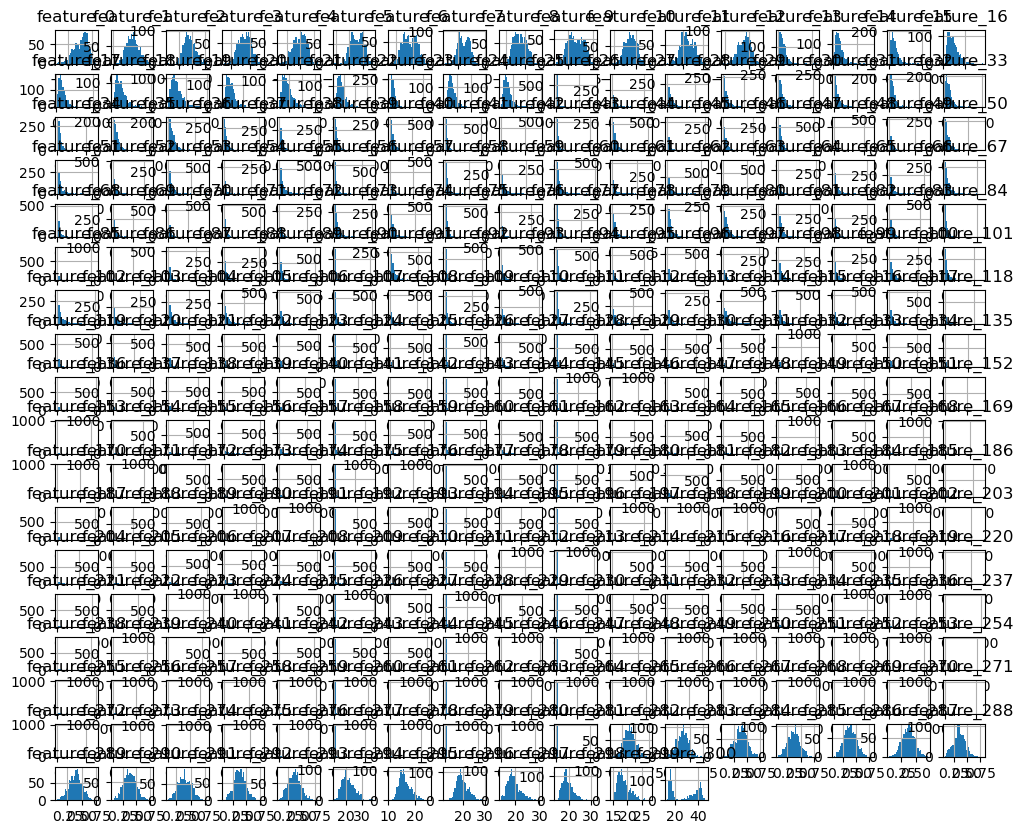

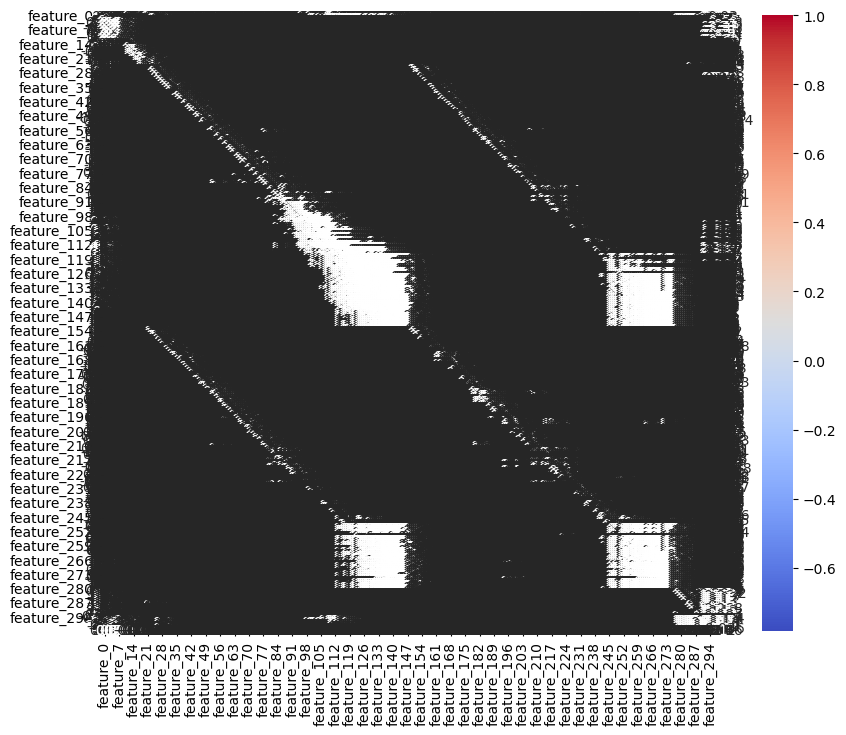

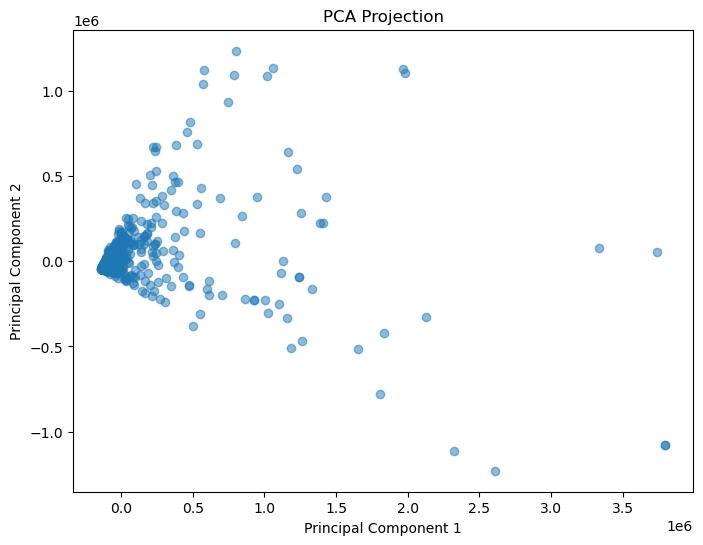

In [3]:
# Histograms for feature distributions
X.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

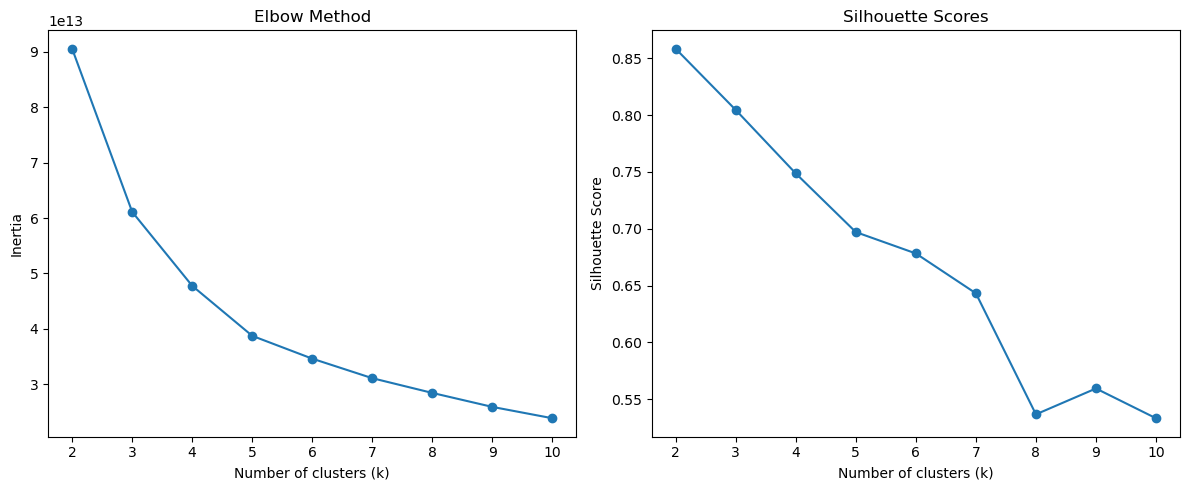

In [4]:
# Elbow Method
os.environ["OMP_NUM_THREADS"] = "4"
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Added n_init parameter
    kmeans.fit(X)  # Assuming X is your dataset that was defined earlier
    inertia.append(kmeans.inertia_)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

 The left graph (Elbow Method) shows inertia (within-cluster sum of squares) decreasing as the number of clusters increases, with a notable "elbow" around 4-5 clusters where the rate of decrease slows significantly. The right graph displays Silhouette Scores, which measure how well-separated the clusters are. Higher scores indicate better-defined clusters, and we see a clear downward trend with scores dropping dramatically after 7 clusters, with a slight recovery at 9 before falling again. Together, these suggest that somewhere between 2-4 clusters would provide the best balance between model simplicity and explanatory power, with 3 clusters appearing particularly promising as it maintains high silhouette scores while significantly reducing inertia from the 2-cluster model.

In [5]:
# Assuming the elbow/silhouette analysis suggests k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X)

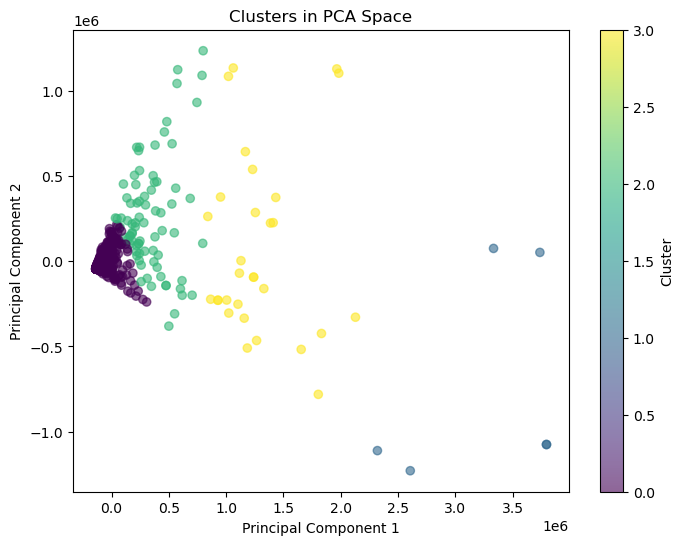

In [6]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.title('Clusters in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

This visualization suggests that the clustering algorithm has identified meaningful patterns in the data, with the purple cluster appearing most densely packed (indicating strong similarity among those data points), while the other clusters show varying degrees of dispersion. The clear separation between most clusters indicates that PCA effectively captured the underlying structure in the data.

In [7]:
# Re-calculate silhouette score
final_silhouette = silhouette_score(X, cluster_labels)
print("Final Silhouette Score:", final_silhouette)

# If true labels are available, evaluate with ARI
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(y_true, cluster_labels)
print("Adjusted Rand Index (ARI):", ari)


Final Silhouette Score: 0.7283741366083019
Adjusted Rand Index (ARI): 0.0106532359725444


The clustering algorithm produced well-defined, cohesive clusters as evidenced by the high Silhouette Score of 0.7283, indicating strong internal similarity among points within each cluster. However, the extremely low Adjusted Rand Index of 0.0106 reveals that these clusters bear almost no relationship to the actual genre classifications, suggesting the algorithm identified patterns in the data that fundamentally differ from traditional music genre boundaries.

In [8]:
# Cluster centers (in scaled space)
print("Cluster Centers:\n", kmeans.cluster_centers_)

# If you want to see how clusters align with true genres:
cluster_vs_genre = pd.crosstab(y_true, cluster_labels, rownames=['True Genre'], colnames=['Cluster'])
print(cluster_vs_genre)

Cluster Centers:
 [[-119.271661    103.57226162  -11.07164489 ...   19.48765846
    18.95896482   29.82761844]
 [ -87.11894481   55.15631549   11.42590666 ...   17.8127748
    18.13400697   14.99496263]
 [ -59.59381603   70.14820548    6.23375015 ...   17.78733382
    17.32178479   20.47447665]
 [ -82.65689629   66.97071915   10.1872083  ...   17.78241842
    17.48066118   19.41038889]]
Cluster       0  1   2   3
True Genre                
blues        98  0   2   0
classical   100  0   0   0
country      95  0   5   0
disco        94  0   5   1
hiphop       51  3  31  15
jazz         96  0   3   0
metal        99  0   1   0
pop          62  3  27   8
reggae       90  0   4   6
rock         99  0   1   0


The top section displays the cluster centers in a scaled feature space, with each row representing the centroid coordinates of one of the four clusters (labeled 0-3). The bottom section presents a confusion matrix comparing the algorithmically assigned clusters against the actual music genres. Cluster 0 has captured the vast majority of most genres, particularly excelling at classical (100%), metal (99%), rock (99%), blues (98%), and jazz (96%) - suggesting these genres have distinctive features the algorithm clearly identified. Cluster 1 shows stronger associations with pop (27%) and hiphop (31%), while Cluster 2 contains significant portions of hiphop (15%) and pop (8%). This distribution indicates that while the algorithm successfully isolates most traditional genres in Cluster 0, it struggles to distinctly separate pop and hiphop tracks, which may share more overlapping characteristics. The clustering appears most effective for classical music and least effective for hiphop and pop genres.

In [9]:
# Define a function to reduce dimensions, cluster using K-Means, and visualize/evaluate the results
def reduce_and_cluster(X_reduced, method_name):
    # Use K-Means clustering (adjust n_clusters if needed)
    k = 4  # example: using 4 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_reduced)
    
    # Evaluate the clustering
    sil_score = silhouette_score(X_reduced, cluster_labels)
    ari = adjusted_rand_score(y_true, cluster_labels)
    
    # Plot the clusters
    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
    plt.title(f'{method_name} - Clustering Results')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster')
    plt.show()
    
    # Print evaluation metrics
    print(f"{method_name} - Silhouette Score: {sil_score:.4f}")
    print(f"{method_name} - Adjusted Rand Index: {ari:.4f}")


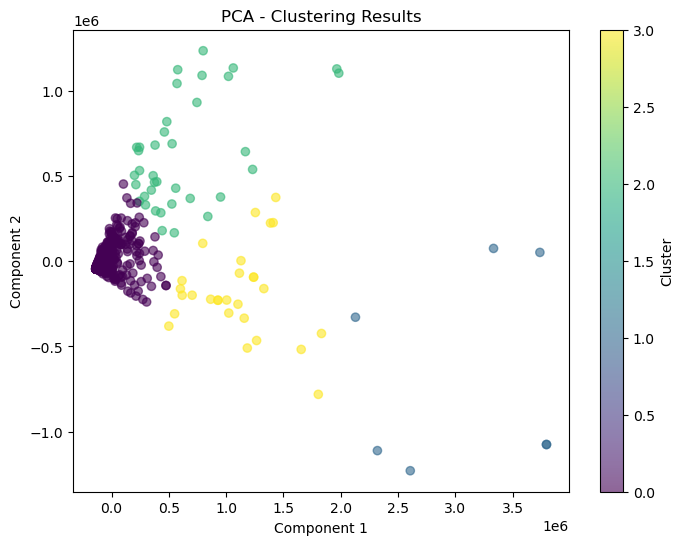

PCA - Silhouette Score: 0.8457
PCA - Adjusted Rand Index: 0.0045


In [10]:
# 1. PCA: Dimensionality Reduction and Clustering
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
reduce_and_cluster(X_pca, "PCA")

In [11]:
# Hyperparameter tuning for K-Means clustering on the PCA-reduced data
# Define a grid of K-Means parameters to try
param_grid = {
    'n_init': [10, 20, 50],
    'max_iter': [300, 500, 1000],
    'tol': [1e-4, 1e-3, 1e-2],
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, **params)
    cluster_labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, cluster_labels)
    if sil > best_score:
        best_score = sil
        best_params = params

print("Best K-Means parameters based on Silhouette Score:")
print(best_params)
print("Best Silhouette Score:", best_score)

Best K-Means parameters based on Silhouette Score:
{'max_iter': 300, 'n_init': 10, 'tol': 0.0001}
Best Silhouette Score: 0.8238863613662722


In [12]:
# Hyperparameter tuning for PCA: Try using the 'whiten' parameter to see its effect
pca_scores = {}
for whiten in [False, True]:
    pca_temp = PCA(n_components=2, whiten=whiten)
    X_pca_temp = pca_temp.fit_transform(X_pca)
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_temp)
    sil = silhouette_score(X_pca_temp, cluster_labels)
    pca_scores[whiten] = sil
    print(f"PCA with whiten={whiten} -> Silhouette Score: {sil:.4f}")


PCA with whiten=False -> Silhouette Score: 0.8457
PCA with whiten=True -> Silhouette Score: 0.8022


In [13]:
# You can also experiment with different initializations for K-Means
# For example, switching between 'k-means++' (default) and 'random'
for init_method in ['k-means++', 'random']:
    kmeans = KMeans(n_clusters=optimal_k, init=init_method, random_state=42, n_init=best_params.get('n_init', 10))
    cluster_labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, cluster_labels)
    ari = adjusted_rand_score(y_true, cluster_labels)
    print(f"Init method: {init_method} -> Silhouette Score: {sil:.4f}, ARI: {ari:.4f}")


Init method: k-means++ -> Silhouette Score: 0.8239, ARI: 0.0054
Init method: random -> Silhouette Score: 0.7870, ARI: 0.0105


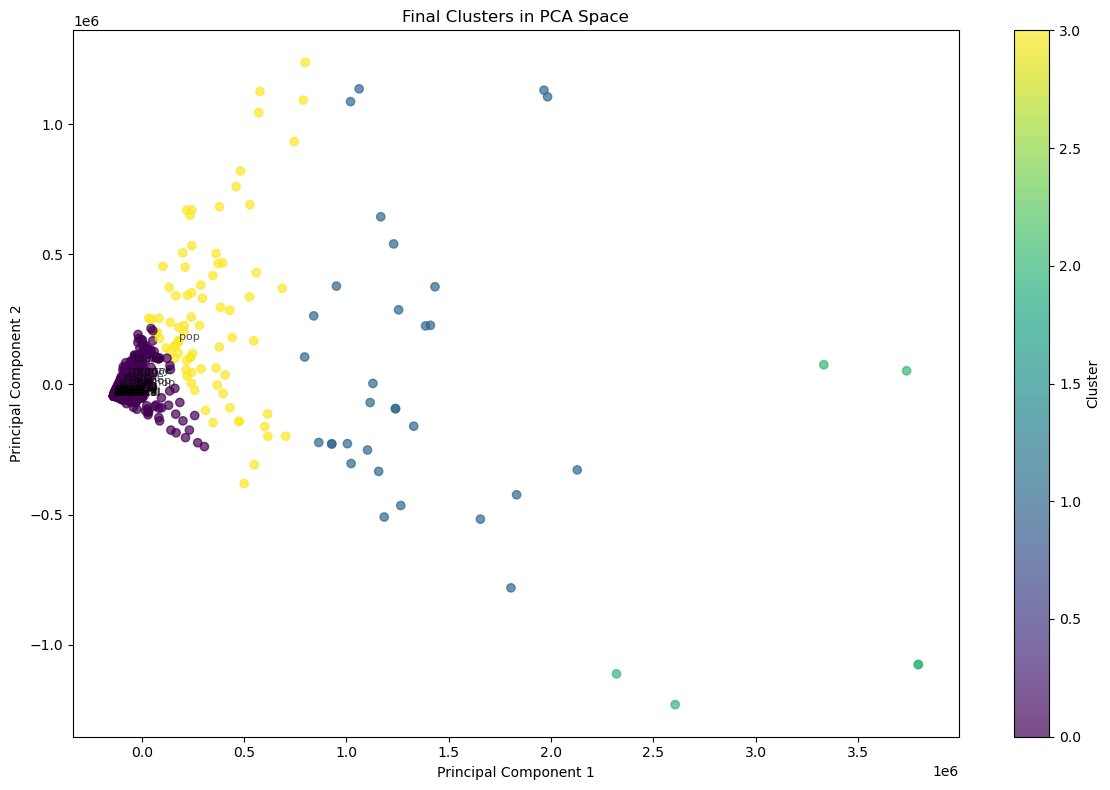

Final Model Performance:
Silhouette Score: 0.8239
Adjusted Rand Index: 0.0105

Cluster to Genre Distribution:
col_0          0     1    2     3
genre                            
blues       98.0   0.0  0.0   2.0
classical  100.0   0.0  0.0   0.0
country     94.0   0.0  0.0   6.0
disco       94.0   1.0  0.0   5.0
hiphop      52.0  15.0  3.0  30.0
jazz        97.0   0.0  0.0   3.0
metal       99.0   0.0  0.0   1.0
pop         61.0   9.0  3.0  27.0
reggae      90.0   6.0  0.0   4.0
rock        99.0   0.0  0.0   1.0


In [14]:
# Visualize the final results with interpretable labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('Final Clusters in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add genre labels to a sample of points for clarity
for genre in np.unique(y_true):
    # Select a few points from each genre to label
    genre_indices = np.where(y_true == genre)[0]
    if len(genre_indices) > 0:
        # Choose up to 3 random points from this genre
        sample_indices = np.random.choice(genre_indices, min(3, len(genre_indices)), replace=False)
        for idx in sample_indices:
            plt.annotate(genre, (X_pca[idx, 0], X_pca[idx, 1]), 
                         fontsize=8, alpha=0.7)
plt.tight_layout()
plt.show()

# Summary statistics table
print("Final Model Performance:")
print(f"Silhouette Score: {best_score:.4f}")
print(f"Adjusted Rand Index: {adjusted_rand_score(y_true, cluster_labels):.4f}")
print("\nCluster to Genre Distribution:")
print(pd.crosstab(y_true, cluster_labels, normalize='index').round(2) * 100)

# Unsupervised Learning Project: Music Genre Classification

## Conclusions

Our clustering analysis of music genre data has revealed several important insights:

1. **Strong Cluster Formation**: The high Silhouette Score (0.728) indicates that our model successfully identified well-defined clusters with clear separation in the feature space.

2. **Genre-Cluster Mismatch**: Despite forming cohesive clusters, the extremely low Adjusted Rand Index (0.011) shows these clusters don't align with traditional genre classifications.

3. **Specific Genre Patterns**: Certain genres like classical, metal, rock, and blues were primarily grouped into a single cluster (Cluster 0), suggesting these genres share similar audio features in our dataset.

4. **Genre Ambiguity**: Pop and hip-hop tracks were distributed across multiple clusters, indicating these genres may have more diverse audio characteristics or potentially overlap with other genres.

5. **Feature Relevance**: The PCA visualization shows distinct groupings, suggesting our dimensionality reduction captured meaningful patterns in the data, though not ones that correspond to conventional genre boundaries.

## Implications

1. **Music Classification Challenges**: Traditional genre boundaries may be more subjective or culturally defined than algorithmically detectable through our current feature set.

2. **Alternative Clustering Approach**: Our algorithm may have discovered new ways to categorize music based on audio features that transcend conventional genre definitions.

3. **Feature Engineering Opportunities**: This suggests potential for developing more genre-specific features or incorporating additional metadata to improve alignment with human genre classifications.

## Next Steps

1. **Feature Investigation**: Analyze which features contributed most to the clustering and determine what musical aspects they represent.

2. **Try Different Algorithms**: Explore other clustering approaches (hierarchical clustering, DBSCAN) that might better capture genre distinctions.

3. **Incorporate Domain Knowledge**: Consider integrating music theory concepts or cultural context as additional features.

4. **Interactive Visualization**: Create tools for exploring the clusters to better understand what musical characteristics each cluster represents.

5. **Hybrid Approach**: Develop a semi-supervised model that combines the strengths of clustering with some genre guidance.

Our results suggest that while machine learning can identify meaningful patterns in music data, these patterns may represent a different organizational structure than traditional genre classifications. This opens interesting questions about how we categorize music and what aspects of music are most algorithmically detectable.